In [1]:
import csv
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, average_precision_score, precision_recall_curve, f1_score
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score, plot_precision_recall_curve 
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt

## Leitura dos dados

No trecho de código abaixo é feita a simples leitura do arquivo que contém os dados. A primeira coluna é descartada por ser apenas a identificação do objeto. A segunda coluna contém os rótulos e é tomada em separado. As demais colunas são colunas de dados.
A coluna de rótulo é mapeada para um valor númerico sendo "1.0" caso seja um exoplaneta confirmado ou "0.0" caso contrário.

In [2]:
data = []
labels = []
with open('koi_data.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(spamreader, None)
    for row in spamreader:
        datum = row[2:]
        datum = [float(i) for i in datum]
        label = (row[1] == 'CONFIRMED')
        if label:
            label = 1.0
        else:
            label = 0.0
        data.append(datum)
        labels.append(label)
data = np.array(data)
labels = np.array(labels)
print(data.shape)
print(labels.shape)

(5202, 41)
(5202,)


Separo parte dos dados para teste. Esses dados não serão em nenhum momento apresentados para os treinamentos e serão usados para a geração de indicadores no final.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)

## Rotina de experimento

Para que todos os experimento sejam executados da mesma forma, fiz uma rotina de experimento que basicamente receberá um constrotor de modelo (model_builder), os hiper-parâmetros pertinentes, dados de entrada e rótulos.

Os dados serão separados em 5 folds para validação cruzada. 

A cada fold os dados são normalizados para evitar vazamento de dados através da normalização.

O modelo é treinado e a acurária é medida.

A acurária da validação cruzada é a média das acurácias medidas para cada fold.

In [4]:
best_results = {}
best_hyper_params = {}
final_model = {}
final_scaler = {}

In [5]:
def fit_model(model_builder, X, y, hyper_params):
    # Faço a normalização por fold para evitar vazamento de informação do treino para validação
    # através dos parametros de normalização
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
        
    model = model_builder(hyper_params)
    model.fit(X, y)
    return model, scaler

def get_accuracy(model, X, y):
    preds = model.predict(X)
    accuracy = accuracy_score(y, preds)
    return accuracy

# Esse método recebe como parametro uma função responsável por criar um novo modelo (sem treinamento)
# de acordo com os valores passados como hiper parametros
def run_experiment(model_builder, X, y, verbose=False, hyper_params=None ):
    kf = KFold(n_splits=5, shuffle=True)
    validation_accuracy = []
    for train_index, val_index in kf.split(X):
        
        # Defino o conjunto de teste e validação do fold
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Treino o modelo baseado no algoritomo selecionado (passado como parâmetro)
        model, scaler = fit_model(model_builder, X_train, y_train, hyper_params)
        
        X_val = scaler.transform(X_val)
        
        # Avalio a acurácia do modelo
        accuracy = get_accuracy(model, X_val, y_val)
        if verbose:
            print('Fold accuracy: {}'.format(accuracy))
        validation_accuracy.append(accuracy)
    
    # Calculo o valor final da validação cruzada (média do resultado de cada fold)
    cross_validation_accuracy = np.mean(np.array(validation_accuracy))
    if verbose:
        print('Cross validation accuracy: {}'.format(cross_validation_accuracy))
    
    return cross_validation_accuracy, hyper_params



## Naive Bayes

Para obter uma base do comparação. O algoritmo Naïve Bayes foi usado para gerar um primeiro modelo.

In [7]:
from sklearn import naive_bayes

def build_naive_bayes(hyper_params):
    return naive_bayes.GaussianNB()

# Executa o experimento
result,_ = run_experiment(build_naive_bayes, X_train, y_train, verbose=True)

best_results['naive_bayes'] = result
best_hyper_params['naive_bayes'] = None

# Ao final dos experimentos, gero o modelo final usando todos os dados de treino e utilizando os híper-parâmetros
# selecionados pelos experimentos
final_model['naive_bayes'], final_scaler['naive_bayes'] = fit_model(build_naive_bayes, X_train, y_train, best_hyper_params['naive_bayes'])

Fold accuracy: 0.9206145966709347
Fold accuracy: 0.9461538461538461
Fold accuracy: 0.9102564102564102
Fold accuracy: 0.9141025641025641
Fold accuracy: 0.9038461538461539
Cross validation accuracy: 0.9189947142059818


# Árvore de decisão

Para a árvore de decisão o hiper-parâmetro que está sendo váriado é a profundidade máxima da árvore.

A loop de busca por hiper-parâmetro varia esse valor entre 1 e 40. Ao final um teste adicional é executado para avaliar o comportamento do modelo caso não seja imposto ao treinamento a restrição a profundidade da rede.

A profundidade da rede determina o número máximo de decisões que a árvore precisa tomar para classificar uma determinada amostra. Como se trata de uma decisão binária, o divisões dos dados crescem de forma exponêncial, podendo rapidamente degradar em overfitting.

In [9]:
from sklearn import tree
depths = []
accuracy = []
hyper_params_list = []

def build_decision_tree_classifier(hyper_params):
    if 'max_depth' in hyper_params:
        return tree.DecisionTreeClassifier(max_depth=hyper_params['max_depth'])
    else:
        # Permite o crescimento indefinido da rede
        return tree.DecisionTreeClassifier()

# Varia o híper-parâmetro
for max_depth in range(1,40):
    hyper_params = {
        'max_depth': max_depth
    }
    # Executa o experimento
    result, _ = run_experiment(build_decision_tree_classifier, X_train, y_train, hyper_params = hyper_params )
    
    depths.append(max_depth)
    accuracy.append(result)
    hyper_params_list.append(hyper_params)
    
no_limits_result, _ = run_experiment(build_decision_tree_classifier, X_train, y_train, hyper_params = {} )

accuracy=np.array(accuracy)
best_result_idx = np.argmax(accuracy)
best_result = accuracy[best_result_idx]
selected_hyper_params = hyper_params_list[best_result_idx]



# Ao final dos experimentos, gero o modelo final usando todos os dados de treino e utilizando os híper-parâmetros
# selecionados pelos experimentos
best_results['decision_tree'] = best_result
best_hyper_params['decision_tree'] = selected_hyper_params
final_model['decision_tree'], final_scaler['decision_tree']  = fit_model(build_decision_tree_classifier, X_train, y_train, best_hyper_params['decision_tree'] )

### Resultados

Como podemos ver no gráfico abaixo, o modelo apresenta um pequeno overfitting na medida em que se permite o aumento da profundidade da rede. O melhor resultado obteve uma precisão de aproximadamente 95.4%. 

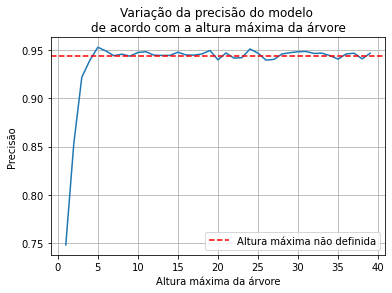

Melhor resultado: 0.953 - {'max_depth': 5}


In [10]:
fig, ax = plt.subplots()
ax.plot(np.array(depths), accuracy)

ax.axhline(y=no_limits_result, color='r', ls='--', label='Altura máxima não definida')

ax.set(xlabel='Altura máxima da árvore', ylabel='Precisão',
       title='Variação da precisão do modelo \nde acordo com a altura máxima da árvore')
ax.grid()
ax.legend()

plt.show()

print('Melhor resultado: {:.3f} - {}'.format(best_results['decision_tree'], best_hyper_params['decision_tree']))

# Support Vector Machines

No caso dos experimentos com SVM o que está sendo variado é o kernel que está sendo utilizado em busca do melhor modelo.

O loop de busca alterna entre os kernels 'linear', 'polinomial', 'rbf' e 'sigmoid', todos os demais parâmetros permanecendo os mesmos em todos os experimêntos.

O kernel define a tranformação que será feita nos dados de entrada com o objetivo de torná-lo linearmente separável. Isso é aumentando a dimensionalidade do dado.

O valor de C foi definido em 128, pois foi o que apresentou melhor resultado em termos de acurácia na validação cruzada. 

In [11]:
from sklearn import svm

def build_support_vector_classifier(hyper_params):
    return svm.SVC(C=128.0, kernel=hyper_params['kernel'], probability=True)
    
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
accuracy = []
hyper_params_list = []

# Varia o híper-parâmetro
for kernel in kernels:
    hyper_params = {
        'kernel': kernel
    }
    result, _ = run_experiment(build_support_vector_classifier, X_train, y_train, hyper_params = hyper_params )
    
    accuracy.append(result)
    hyper_params_list.append(hyper_params)
    
accuracy=np.array(accuracy)
best_result_idx = np.argmax(accuracy)
best_result = accuracy[best_result_idx]
selected_hyper_params = hyper_params_list[best_result_idx]


# Ao final dos experimentos, gero o modelo final usando todos os dados de treino e utilizando os híper-parâmetros
# selecionados pelos experimentos
best_results['svm'] = best_result
best_hyper_params['svm'] = selected_hyper_params
final_model['svm'], final_scaler['svm'] = fit_model(build_support_vector_classifier, X_train, y_train, best_hyper_params['svm'] )


### Resultados

Como pode ser observado nos gráficos abaixo, o kernel que apresentou o melhor resultado foi o polinomial, mas acompanhado bastante de perto do RBF e do kernel linear. Isso é uma indicação que o modelo não está se beneficiando muito do aumento de dimensionalidade.

O kernel selecionado foi o polinomial, com uma acurácia de aproxiamdamente 95%.

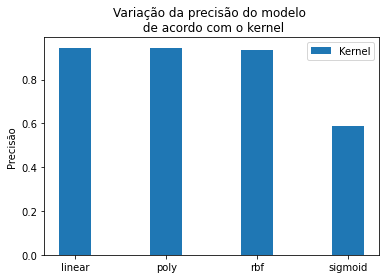

Melhor resultado: 0.946 - {'kernel': 'poly'}


In [13]:
x = np.arange(len(kernels))
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects2 = ax.bar(x , accuracy, width, label='Kernel')


ax.set_ylabel('Precisão')
ax.set_title('Variação da precisão do modelo \n de acordo com o kernel')
ax.set_xticks(x)
ax.set_xticklabels(kernels)
ax.legend()

plt.show()

print('Melhor resultado: {:.3f} - {}'.format(best_results['svm'], best_hyper_params['svm']))

# K Neighbours

Esse algoritmo busca classificar uma amostra baseado nos rótulos das amostras de treino que estão mais próximas no espaço de caracteristicas.

Esse algoritmo pode na verdade ser implementado de diversas maneiras (força-bruta, KDTree...). No caso da biblioteca sklearn esse algoritmo interno pode ser passado como parâmetro ou você pode permitir que o próprio sklearn faça a escolha basesado nos valores de treino que ele recebe. Nos experimentos abaixo essa estratégia foi adotada, ou seja, o algoritmo interno de otimização foi escolhido pelo próprio sklearn.

O hiper-parâmetro que foi analisado no experimento foi o número de vizinhos avaliados na classificação, ou seja, quantos vizinhos serão analisados para definir a classe da minha amostra. Valores muito pequenos podem sujeitar seu modelo a ruídos, dado que um outlier irá atrapalhar a classificação de todos a sua volta. Valores muito grandes pode ser problemático, especialmente em regiões de transição entre uma classificação e outra.

In [15]:
from sklearn.neighbors import KNeighborsClassifier

def build_k_neighbours_classifier(hyper_params):
    return  KNeighborsClassifier(n_neighbors=hyper_params['n_heigh'])

n_heighs = []
accuracy = []
hyper_params_list = []

# Varia o híper-parâmetro
for n_heigh in range(1, 30):
    hyper_params = {
        'n_heigh': n_heigh
    }
    result, _ = run_experiment(build_k_neighbours_classifier, data, labels, hyper_params = hyper_params )
    
    accuracy.append(result)
    n_heighs.append(n_heigh)
    hyper_params_list.append(hyper_params)
    
accuracy=np.array(accuracy)
best_result_idx = np.argmax(accuracy)
best_result = accuracy[best_result_idx]
selected_hyper_params = hyper_params_list[best_result_idx]


# Ao final dos experimentos, gero o modelo final usando todos os dados de treino e utilizando os híper-parâmetros
# selecionados pelos experimentos
best_results['k_neighbours'] = best_result
best_hyper_params['k_neighbours'] = selected_hyper_params
final_model['k_neighbours'], final_scaler['k_neighbours'] = fit_model(build_k_neighbours_classifier, X_train, y_train, best_hyper_params['k_neighbours'] )

### Resultados

Como pode ser observado o melhor resultado foi obtido com o algoritmo considerando em torno de 6 vizinhos mais próximos (pode variar de acordo com o experimento). No entanto, mesmo no melhor caso, a acurária obteve um valor relativamente baixo comparado com os métodos anteriores.

Para valores acima de 6 para o hiper-parâmentro percebe-se uma tendência a uma queda na acurácia.

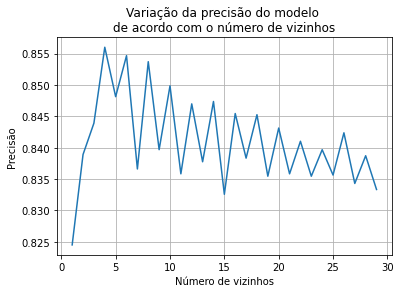

Melhor resultado: 0.856 - {'n_heigh': 4}


In [16]:
   
fig, ax = plt.subplots()
ax.plot(np.array(n_heighs), np.array(accuracy))

ax.set(xlabel='Número de vizinhos', ylabel='Precisão',
       title='Variação da precisão do modelo \nde acordo com o número de vizinhos')
ax.grid()

plt.show()

print('Melhor resultado: {:.3f} - {}'.format(best_results['k_neighbours'], best_hyper_params['k_neighbours']))

# Random Forest

O Random Forest é na verdade um algoritmo que agrupa um conjunto  de árvores de decisão. O treinamento de cada uma das árvores é feito a partir de um sub conjunto dos dados de treino e a predição é feita com base em uma média das classificações de cada estimador treinado. Esses fatores lhe dá a caracteristica de ser mais resistênte a overfitting.

Nos experimentos será variado o hiper-parâmetro de número de estimadores, ou seja, o número de árvores que farão parte da floresta.

In [17]:
from sklearn.ensemble import RandomForestClassifier

def build_random_forest_classifier(hyper_params):
    return  RandomForestClassifier(n_estimators=hyper_params['n_estimators'])

n_trees = []
accuracy = []
hyper_params_list = []

# Varia o híper-parâmetro
for n_estimators in range(1,100, 5):
    hyper_params = {
        'n_estimators': n_estimators
    }
    result, _ = run_experiment(build_random_forest_classifier, data, labels, hyper_params = hyper_params )
    
    accuracy.append(result)
    n_trees.append(n_estimators)
    hyper_params_list.append(hyper_params)
    
accuracy=np.array(accuracy)
best_result_idx = np.argmax(accuracy)
best_result = accuracy[best_result_idx]
selected_hyper_params = hyper_params_list[best_result_idx]

# Ao final dos experimentos, gero o modelo final usando todos os dados de treino e utilizando os híper-parâmetros
# selecionados pelos experimentos
best_results['random_forest'] = best_result
best_hyper_params['random_forest'] = selected_hyper_params
final_model['random_forest'], final_scaler['random_forest'] = fit_model(build_random_forest_classifier, X_train, y_train, best_hyper_params['random_forest'] )

### Resultados

Conforme esperado o acrescimo de mais árvores melhorou a performance do modelo. Esse crescimento de performance no entanto se saturou na faixa de 97% de precisão após o número de 25 estimadores, indicando que pouco se está ganhando com o acrescimo na complexidade do modelo após esse ponto. Importante destacar que esse algoritmo apresentou uma melhora de performance significativa em relação aos modelos anteriores.

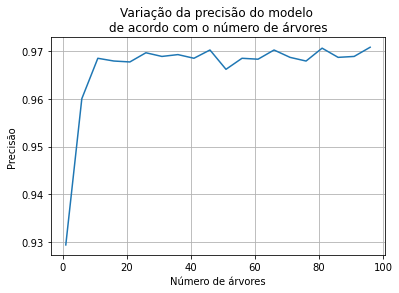

Melhor resultado: 0.971 - {'n_estimators': 96}


In [20]:
fig, ax = plt.subplots()
ax.plot(np.array(n_trees), np.array(accuracy))

ax.set(xlabel='Número de árvores', ylabel='Precisão',
       title='Variação da precisão do modelo \nde acordo com o número de árvores')
ax.grid()

plt.show()

print('Melhor resultado: {:.3f} - {}'.format(best_results['random_forest'], best_hyper_params['random_forest']))

# Gradient Tree Boosting

A idéia por trás dos algoritmos de boosting é que, através da junção de uma série de classificadores fracos (ou seja, que possuem baixa performance, mas que são melhores que o aleatório) é possível construir um classificador forte. No caso do Gradient Boosting, os classificadores (pequenas árvores de descisão) são adicionados ao conjunto na medida em que minimizam uma função de perda, num procetimento semelhante a uma descida de gradiente. Algoritmos de boosting são conhecidos por serem resistêntes a overfitting.

Na execução do algoritmo, a cada interação é adicionado um novo classificador. Portanto variar o número de estimadores permitidos é variar o número de interações. Esse será o hiper-parâmetro que será variado no experimento.



In [21]:
from sklearn.ensemble import GradientBoostingClassifier

def build_boosting_classifier(hyper_params):
    return  GradientBoostingClassifier(n_estimators=hyper_params['n_estimators'])

n_stages = []
accuracy = []
hyper_params_list = []

# Varia o híper-parâmetro (neste caso de forma logaritmica)
for n_estimators in np.floor(np.logspace(0, 2.5, num=10)).astype(int):
    hyper_params = {
        'n_estimators': n_estimators
    }
    result, _ = run_experiment(build_boosting_classifier, data, labels, hyper_params = hyper_params )
    
    accuracy.append(result)
    n_stages.append(n_estimators)
    hyper_params_list.append(hyper_params)

accuracy=np.array(accuracy)
best_result_idx = np.argmax(accuracy)
best_result = accuracy[best_result_idx]
selected_hyper_params = hyper_params_list[best_result_idx]

# Ao final dos experimentos, gero o modelo final usando todos os dados de treino e utilizando os híper-parâmetros
# selecionados pelos experimentos
best_results['boosting'] = best_result
best_hyper_params['boosting'] = selected_hyper_params
final_model['boosting'], final_scaler['boosting'] = fit_model(build_boosting_classifier, X_train, y_train, best_hyper_params['boosting'] )    


### Resultados

Conforme esperado um aumento no número de interações permitiu um aumento no número de estimadores que, por consequência, fez com que o modelo obtivesse um ganho de desempenho. Assim como no caso das Random Forests, também pode se perceber que os ganhos de performance se saturam, também nesse caso próximo de 97%. Portanto não se  justificando um aumento exagerado no número de estimadores, pois aumenta-se a complexidade do modelo (e tempo de treinamento) sem em contrapartida se perceber um ganho significativo de desempenho.

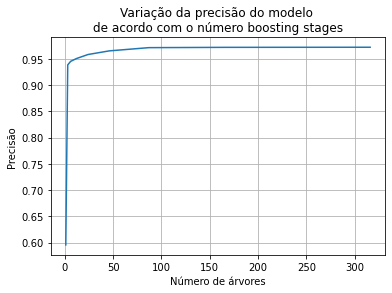

Melhor resultado: 0.972 - {'n_estimators': 316}


In [22]:
fig, ax = plt.subplots()
ax.plot(np.array(n_stages), np.array(accuracy))

ax.set(xlabel='Número de árvores', ylabel='Precisão',
       title='Variação da precisão do modelo \nde acordo com o número boosting stages')
ax.grid()

plt.show()

print('Melhor resultado: {:.3f} - {}'.format(best_results['boosting'], best_hyper_params['boosting']))

# Curva ROC

A curva ROC é um método para avaliar modelos de classificação binária. Através dela analisa-se como o modelo se comportam os erros de classificação em relação às classificações corretas, variando o parâmetro de threshold que define o valor a partir do qual um valor de saída pertence a uma classe ou a outra. 

Idealmente o modelo apresentaria uma curva passando pelo ponto (0,1), o que siginificaria a não ocorrência de falsos positivos e a correta classificação de todos os verdadeiramente positivos.

Uma maneira simples de comparar métodos é através da área delimitada pela curva. Quanto mais próximo do 1 o valor dá área, mais próximo se estará do cenário ideal.

Para os modelos testados, os valores das áreas sob a curva ROC podem ser vistos na legenda da figura abaixo. 

Baseado nesses valores podemos perceber que os classificadores que apresentaram melhor desempenho foram o Random Forest e o Gradient Boosting, ambos com um indice de aproximadamente 0.97, ou seja, muito próximo do ideal.

Já o de pior desempenho foi o K-Neighbours, que apresentou um índice de aproximadamente 0.85. 

<Figure size 432x288 with 0 Axes>

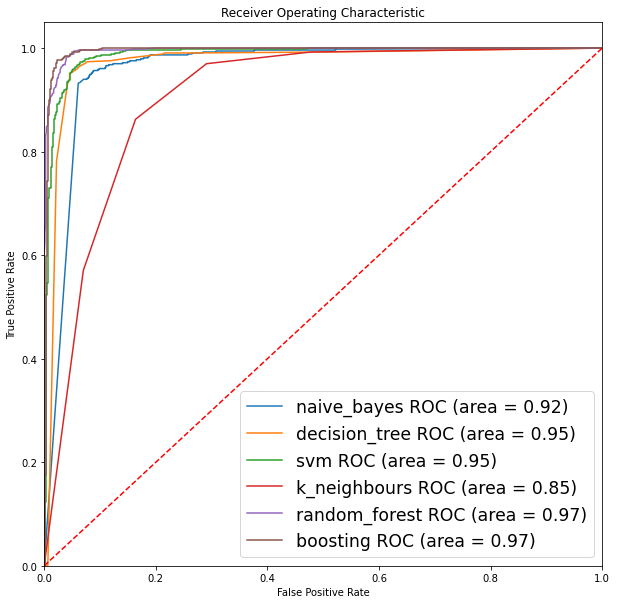

In [23]:
plt.figure()
plt.figure(figsize=(10,10))

for model_name in final_model:
    scaler = final_scaler[model_name]
    X_norm = scaler.transform(X_test)
    y_pred = final_model[model_name].predict(X_norm)
    y_proba = final_model[model_name].predict_proba(X_norm)[::,1]
    # y_score = final_model[model_name].decision_function(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (model_name, auc))
    
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right", fontsize='xx-large')
plt.show()   # Display

# Precisão x Revocação

Precisão-Revocação é uma medida importante da qualidade da predição quando se tem um problema em que as classes são desbalanceadas.

Um sistema com alta revocação e baixa precisão, classifica como positivo muitas amostras de entrada, porém muitas delas classificadas incorretamente. Já no extremo oposto, num sistema de baixa revocação, mas alta precisão, o número de amostras classificadas como positivas é baixo, mas essas amostras estarão em sua maioria corretamente classificadas. Num sistema ideal, precisão e revocação são altas.

Sintetizando os conceitos, temos:

Precisão = De todas as amostras que foram classificadas como positivas, quantas efetivamente são positivas.

Revocação = De todas as amostras que são efetivamente positivas, quantas foram classificadas como positivas.

Importante destacar que o crescimento da precisão não necessariamente implica na redução da revocação (e vice versa).


O gráfico abaixo mostra a relação entre precisão e revocação para diferentes valores de threshold. Na legenda está incluído também a métrica F1 que consolida em apenas um indicador as medidas de precisão e revocação. O valor ideal para a métrica F1 é "1.0".

Também nesse quesito podemos verificar que os algoritmos Random Forest e Gradient Boosting são os de melhor performance, mas com uma pequena vantagem para o Gradient Boosting.

<Figure size 432x288 with 0 Axes>

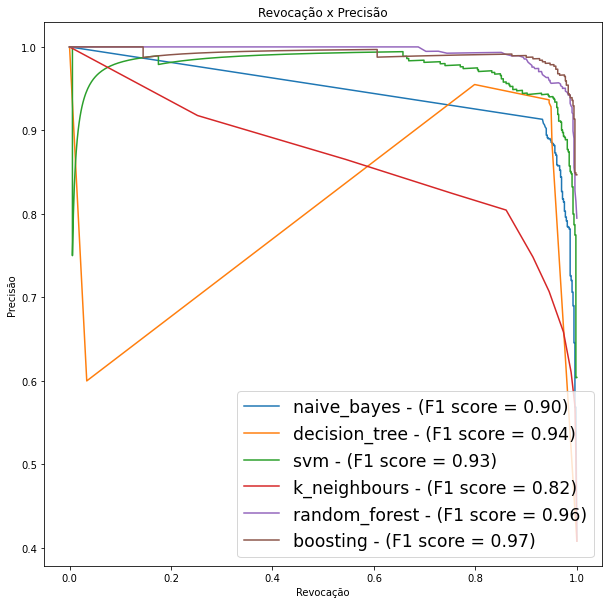

In [50]:


plt.figure()
plt.figure(figsize=(10,10))

for model_name in final_model:
    scaler = final_scaler[model_name]
    X_norm = scaler.transform(X_test)
    y_pred = final_model[model_name].predict(X_norm)
    yproba = final_model[model_name].predict_proba(X_norm)[::,1]
    precision, recall, thresholds = precision_recall_curve(y_test, yproba)
    average_precision = f1_score(y_test, y_pred)
    
    plt.plot(recall, precision, label='{} - (F1 score = {:.2f})'.format(model_name, average_precision))
    
plt.xlabel('Revocação')
plt.ylabel('Precisão')
plt.title('Revocação x Precisão')
plt.legend(loc="lower right", fontsize='xx-large')
plt.show()   # Display